In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# clustering functions
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

# SARIMA model and autocorrelation plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# SARIMA model throws lots of MLE convergence errors
import warnings
warnings.filterwarnings("ignore")

### Initialization

The following cells load and prep the data. To simplify the analysis, only 2015 data is included.

In [2]:
# read meta and elec data from csv into new dataframes, then fix datetimes
meta = pd.read_csv('../data/building_data_genome_project/bdgp_meta.csv',index_col=0)
meta['datastart'] = pd.to_datetime(meta['datastart'],format='%d/%m/%y %H:00')
meta['dataend'] = pd.to_datetime(meta['dataend'],format='%d/%m/%y %H:00')

raw_elec = pd.read_csv('../data/building_data_genome_project/bdgp_elec.csv',index_col=0)
raw_elec.index = pd.to_datetime(raw_elec.index,format='%Y-%m-%d %H:00:00+00:00')
del raw_elec.index.name

In [3]:
# change names of some meta values for simplicity
meta = meta.rename({'primaryspaceusage':'usage'},axis=1)
meta['usage'] = meta['usage'].map({'Office':'Office',
                                   'Dormitory':'Dormitory',
                                   'College Laboratory':'Laboratory',
                                   'College Classroom':'Classroom'
                                  })

# 0 is arizona state, 1 is europe, 2 is cornell (very good data), 3 is michigan, 4 is princeton, 5 is europe
arizona_meta = meta[meta['newweatherfilename'] == 'weather0.csv']
cornell_meta = meta[meta['newweatherfilename'] == 'weather2.csv']
michigan_meta = meta[meta['newweatherfilename'] == 'weather3.csv']
princeon_meta = meta[meta['newweatherfilename'] == 'weather4.csv']

In [4]:
# initialize the elec demand dataframe, moving 5 hours from 2016 to beginning of 2015 for simplicity
elec = raw_elec[list(cornell_meta.index)].loc['2015-01-01 0:00:00':'2015-12-31 23:00:00']
elec.iloc[0:5]=raw_elec[list(cornell_meta.index)].loc['2016-01-01 00:00:00':'2016-01-01 04:00:00'].values
elec.head(2)

,Office_Caleb,Office_Cameron,Office_Carissa,Office_Carolina,Office_Catherine,Office_Cecelia,Office_Charles,Office_Clarissa,Office_Clifton,Office_Clinton,...,UnivLab_Christine,UnivLab_Christy,UnivLab_Ciel,UnivLab_Cindy,UnivLab_Clint,UnivLab_Clodagh,UnivLab_Collin,UnivLab_Cory,UnivLab_Cristian,UnivLab_Crystal
2015-01-01 00:00:00,35.750,433.950012,86.574997,30.424999,104.575005,8.175,149.399994,7.975,15.475,93.849998,...,183.574997,47.700001,256.224991,67.974998,7.225,37.900002,165.550003,460.125000,740.975021,50.50
2015-01-01 01:00:00,35.625,405.175003,86.550003,30.775002,105.400002,8.025,149.475006,7.975,15.425,101.050003,...,180.324997,45.349998,252.824997,64.875000,7.275,37.924999,161.225006,449.700012,741.274979,49.25


### Clustering

The follow cells implement scipy's hierarchical clustering algorithm on the average hour-of-day and average day-of-week for each building.

https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

In [5]:
# calculate the average day-of-week and hour-of-day profiles, then apply sklearn minmaxscaler
scaler = MinMaxScaler()

hour_of_day = elec.groupby(elec.index.hour).sum()
day_of_week = elec.groupby(elec.index.dayofweek).sum()
hour_of_day_norm = pd.DataFrame(scaler.fit_transform(hour_of_day.values),columns=hour_of_day.columns)
day_of_week_norm = pd.DataFrame(scaler.fit_transform(day_of_week.values),columns=day_of_week.columns)

0.8696719161615697

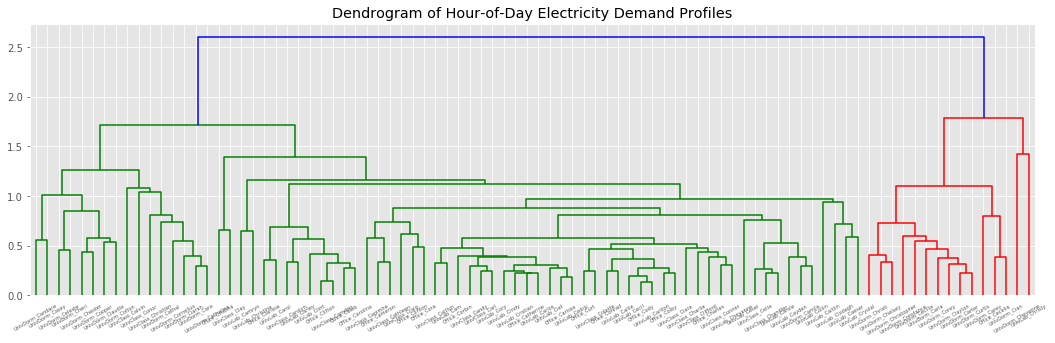

In [6]:
# create the hour-of-day linkage matrix hod_linkage
hod_linkage = linkage(hour_of_day_norm.values.T,'average')
labels = hour_of_day_norm.columns

# plot the dendrogram
plt.figure(figsize=(18, 5))
dendrogram(hod_linkage,orientation='top',labels=labels,distance_sort='descending',)
plt.xticks(rotation=30)
plt.title('Dendrogram of Hour-of-Day Electricity Demand Profiles')

# calculate the cophenetic correlation coefficient, a clustering evaluation metric (>0.75 is good)
clustering_score, coph_dists = cophenet(hod_linkage, pdist(hour_of_day_norm.values.T))
clustering_score

0.6089287760747909

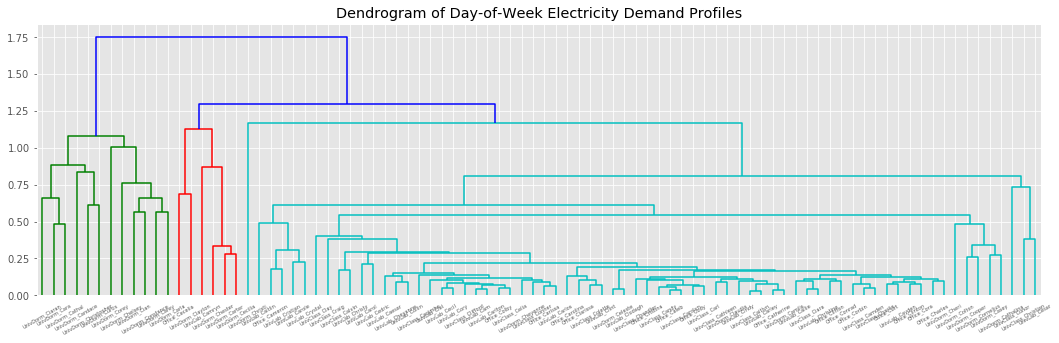

In [7]:
# repeat the process for the average day-of-week data
dow_linkage = linkage(day_of_week_norm.values.T,'average')
labels = day_of_week_norm.columns

plt.figure(figsize=(18,5))
dendrogram(dow_linkage,orientation='top',labels=labels,distance_sort='descending')
plt.xticks(rotation=30)
plt.title('Dendrogram of Day-of-Week Electricity Demand Profiles')

clustering_score, coph_dists = cophenet(dow_linkage, pdist(hour_of_day_norm.values.T))
clustering_score

The dendrograms support two and three clusters based on hour-of-day and day-of-week profiles, respectively. The next cell defines these clusters and plots the results.

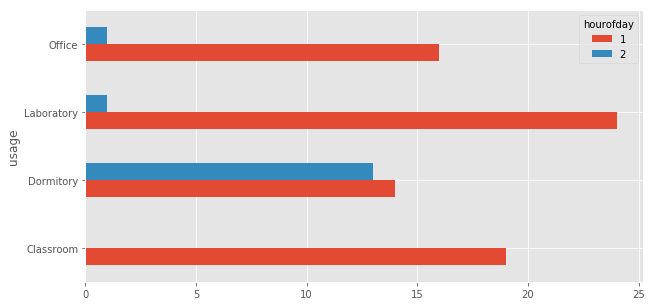

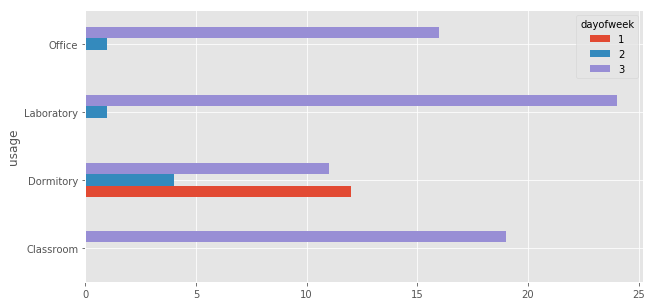

In [8]:
# create clusters based on dendrograms, middle argument gives number of clusters
hod_clustering = fcluster(hod_linkage,2,criterion='maxclust')
dow_clustering = fcluster(dow_linkage,3,criterion='maxclust')

# populate a clusters dataframe based on the results of the clustering analysis
clusters = pd.DataFrame(cornell_meta['usage'],index=list(cornell_meta.index))
clusters['hourofday'], clusters['dayofweek'] = hod_clustering, dow_clustering

# plot the breakdown of each usage into clusters
hod_matrix = pd.crosstab(clusters['usage'],clusters['hourofday'])
dow_matrix = pd.crosstab(clusters['usage'],clusters['dayofweek'])
hod_matrix.plot(kind='barh',figsize=(10,5))
dow_matrix.plot(kind='barh',figsize=(10,5))

Moving on, the two hour-of-day clusters will be used. Clustering based on hour-of-day is probably more effective than day of week, because the day of week effects can be controlled more effectively using transformers. However, this assumption will be tested moving forward.

In [100]:
# define clusters 1 and 2 based on hour of day clusters from above
cluster1_buildings = [elec.columns[k] for k in range(len(elec.columns)) if hod_clustering[k] == 1]
cluster2_buildings = [elec.columns[k] for k in range(len(elec.columns)) if hod_clustering[k] == 2]

cluster1 = pd.Series(elec[cluster1_buildings].sum(axis=1))
cluster2 = pd.Series(elec[cluster2_buildings].sum(axis=1))
agg = pd.Series(elec.sum(axis=1))

### Transformation of median-shifting features

Many predictive models require stationary data. Electricity demand data is never stationary, because it includes seasonal (daily, weekly, yearly) effects as well as trend (steady/exponential increase) effects.

The following cells make the data stationary by calculating and then removing the hour-of-week (weekend vs weekday) and week-of-year (spring break vs class in session) effects.

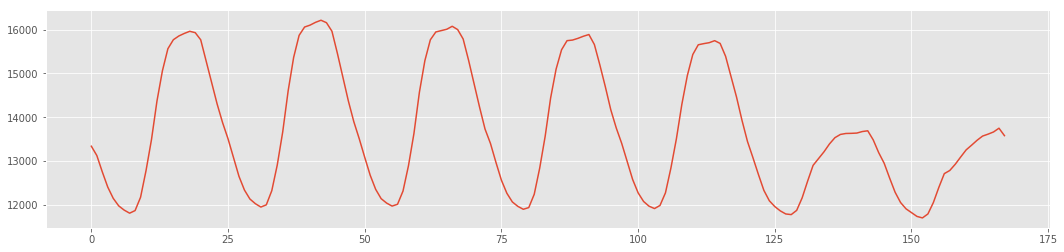

In [101]:
# choose which cluster to analyze
y = cluster1.copy(deep=True)

# calculate hour-of-week and week-of-year averages to isolate weekend, holiday median-shifting
hourofweekarray, hourofweek = range(168),range(72,168) # 2015 starts on a thursday
while len(hourofweek) < 10000: hourofweek = np.append(hourofweek,hourofweekarray)
hourofweek = hourofweek[:8760]

avg_week = y.groupby(hourofweek).mean()
avg_week_transformer = np.vectorize(avg_week.to_dict().get)(hourofweek)

avg_year = y.groupby(y.index.weekofyear).mean()
avg_year_transformer = y.index.weekofyear.map(avg_year)

# plot average hour-of-week to demonstrate the transformer
avg_week.plot(figsize=(18,4),x='Hour of Week',y='kW')

As you can see in the "stationary" plot below, the transformations used do not accurately remove the effects of holidays shorter than one week, like the 4th of July, Thanksgiving, Christmas. To improve the model, these could be hard-coded or identified by clustering with weekends over multiple years of data.

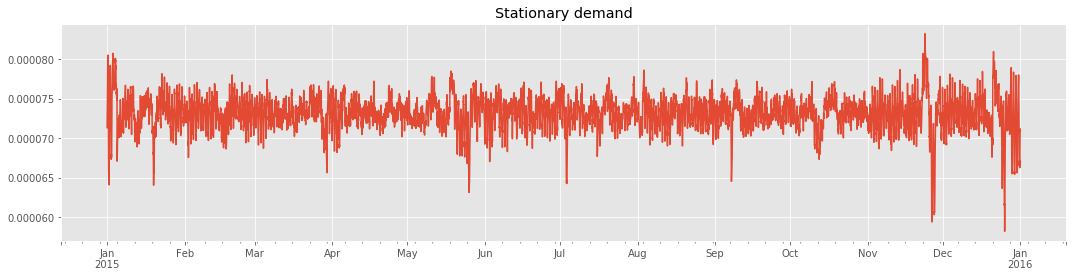

In [102]:
y_stationary = y/avg_week_transformer/avg_year_transformer
y_stationary.plot(figsize=(18,4),title='Stationary demand')

### Autocorrelation plots

The plots below show the autocorrelation and partial autocorrelation of the raw demand data. The shaded red cone shows the 95% confidence interval, meaning all dots outside of the cone are statistically significant. The dots themselves represent lag features, where the first dot is lag by one hour, and the second by two hours.

Following the Box-Jenkins methodology, these plots can be used to inform the type of ARIMA model to be used. https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

See how the 24th and 48th lag features have a strong positive correlation - this indicates that a seasonal component of 24 hours should be modeled.

In [103]:
# plot_acf(y_stationary, lags=50)
# plt.show()
# plot_pacf(y_stationary, lags=24)
# plt.show()

### Predictive Modeling: Seasonal ARIMA

The SARIMA (seasonal autoregressive integrated moving average) model has four parameters: P,D,Q, and m. P,D, and Q are the *seasonal* autoregressive, differencing, and moving average terms, while m is the period. For the demand data, m should be 24. SARIMA also supports trend terms, but there is no trend in this data, so they will not be used.

The cells below train and test SARIMA models for several days in of the training set, starting on February 1st. The MAPE of each daily forecast is stored in the mapes DataFrame, and the predictions are stored in the y_forecast Series.

In [132]:
def SARIMA_forecast(y,start,num_days,trend_params,seasonal_params):
    """
    Uses SARIMA to perform day-ahead predictions
    y: Series to test 
    start: str datetime to start predictions, must be 08:00:00
    num_days: The number of days to predict - also the number of models run
    trend_params, seasonal_params: SARIMA model parameters
    
    Returns: pandas Series of forecasted values, indexed like y
    """
    # define split times and end times to cut X and y into training and testing sets
    split_times = pd.date_range(start=start,freq='D',periods=num_days)
    end_times = split_times.shift(39,freq='H')

    # initialize series to store results
    y_forecast = y.copy(deep=True)
    
    # loop to run models and add hours_trained & mape data to the mapes dataframe
    for i in range(num_days):

        # define train set based on split_times and end_times
        y_train = y.loc[y.index <= split_times[i]].copy().values

        # fit the model training data, then make multi-step out-of-sample forecast
        model = SARIMAX(y_train, order=trend_params,seasonal_order=seasonal_params,enforce_stationarity=False)
        model_fit = model.fit(disp=0,maxiter=200)
        forecast = model_fit.forecast(steps=39)

        # store the forecast results
        y_forecast.loc[(y.index > split_times[i]) & (y.index <= end_times[i])] = forecast

    return y_forecast[split_times[0]+pd.Timedelta(hours=16):end_times[i]]

In [134]:
num_days = 5
start = '2015-02-01 08:00:00'
trend_params = (0,0,0)
seasonal_params = (1,0,1,24)

agg_forecast = SARIMA_forecast(y,start,num_days,trend_params,seasonal_params)
cluster1_forecast = SARIMA_forecast(cluster1,start,num_days,trend_params,seasonal_params)
cluster2_forecast = SARIMA_forecast(cluster2,start,num_days,trend_params,seasonal_params)

In [106]:
# reverse the transformations
y_forecast = y_forecast_stationary*avg_week_transformer*avg_year_transformer

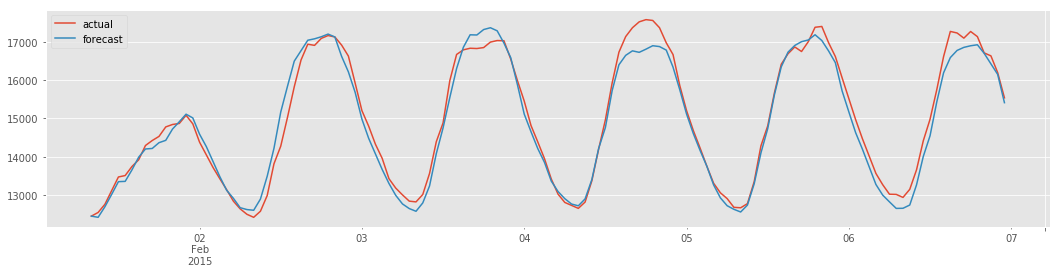

In [107]:
# plot all of the day-ahead forecasts against the actual data
forecast = pd.DataFrame({'actual':y[split_times[0]:end_times[i]],
                         'forecast':y_forecast[split_times[0]:end_times[i]]}
                       )
forecast.plot(figsize=(18,4))

In [113]:
# manual iteration; store results of forecasting on different clusters

# cluster1_forecast = forecast
# cluster2_forecast = forecast
clustered_forecast = cluster1_forecast + cluster2_forecast

aggregate_forecast = forecast

In [114]:
np.mean(np.abs((clustered_forecast['actual'] - clustered_forecast['forecast']) / clustered_forecast['actual']))*100



1.4824917563399103

In [115]:
np.mean(np.abs((aggregate_forecast['actual'] - aggregate_forecast['forecast']) / aggregate_forecast['actual']))*100



1.4852680787917767